# 1D Simulation Example

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as sc
from numpy.typing import NDArray
from espic.init_charges import Initialize
from espic.make_grid import Uniform1DGrid
from espic.run_espic import RunESPIC

## Initialize parameters.
Several of these have defaults, but we define all of them here for the tutorial purposes.
Most of these parameters are typical of PDEs, i.e. initial/boundary conditions, number of particles, etc.

### Particle Parameters

In [2]:
num_particles: int = 500
num_grid_points: int = 1000
dim: int = 1

### Grid and Temporal Parameters

In [3]:
x_min = -10
x_max = 10
dt = 1e-5
t_max = 5e-2
grid = Uniform1DGrid(x_min=x_min, x_max=x_max, num_points=num_grid_points)

### Plasma Parameters

In [4]:
ne: float = num_particles / (x_max)
q: float = sc.e
m: float = sc.m_e
omega_p: float = np.sqrt(ne * q**2 / (m * sc.epsilon_0))
physical_parameters = {"q": q, "m": m, "c": sc.c, "ne": ne, "vth": 0}

### Initial Perturbation and State of Particles

In [5]:
k = 2 / (2 * x_max)
init_pos = Initialize(num_particles, dim).sinusoidal(k, grid.grid)
init_vel = np.zeros(num_particles)
signs = (
    np.sin(2 * np.pi * init_pos * k) / np.abs(np.sin(2 * np.pi * init_pos * k))
).reshape(num_particles)
init_vel = init_vel.reshape((len(init_vel), 1))
init_pos = init_pos.reshape((len(init_pos), 1))

### Boundary Conditions

In [6]:
boundaries = {"left": -10, "right": 10}
boundary_conditions = np.zeros(2)

### Putting it all together

In [7]:
init_state = {"initial position": init_pos, "initial velocity": init_vel}
perturbation = {"signs": signs, "k": k}
resolution = {
            "number of particles": num_particles,
            "number of grid points": num_grid_points,
            "dimension": dim,
        }
time_param = {"dt": dt, "t_max": t_max}

## Run ESPIC!
All of the initializations of the computational modules (Maxwell solver, particle pusher, etc.) are handled internally.

In [8]:
run_espic = RunESPIC(
    init_state,
    boundary_conditions,
    boundaries,
    physical_parameters,
    perturbation,
    resolution,
    time_param,
    normalize=False,
)

run_espic.run()

## Post-processing.
As explained in the report, for a cold plasma, we expect the plasma oscillate at the plasma frequency. We can view the frequency spectrum by taking FFTs in space and time.
Although this model is fully kinetic, we still expect a spike near the plasma frequency (in red).

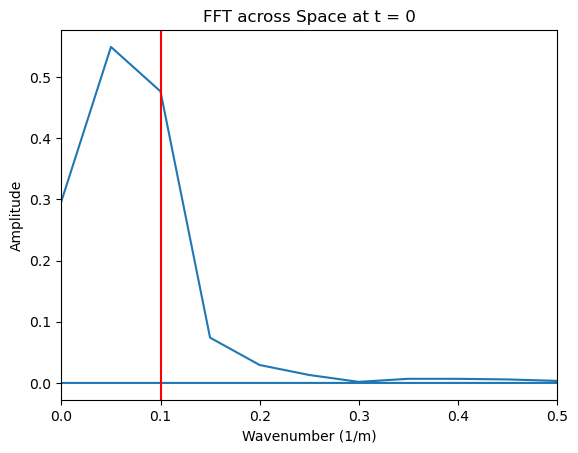

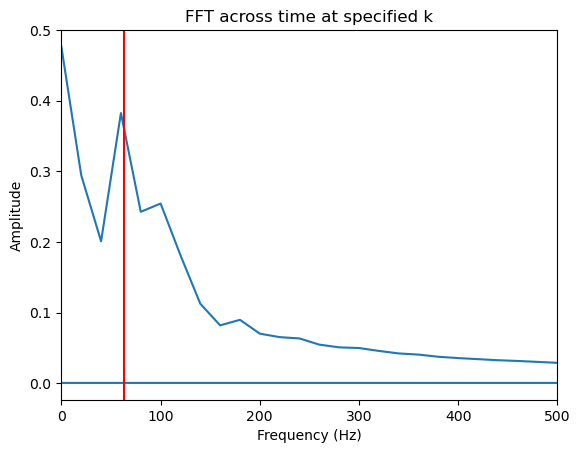

In [9]:
phi_v_time_arr = run_espic.phi_v_time
freq, k_arr, fft = run_espic.compute_fft(phi_v_time_arr)

# Plot space fft of initial phi to verify we have the right k
plt.figure(1)
specific_k = k_arr[1]
plt.plot(k_arr, fft[0, :])
plt.xlim([0, 0.5])
plt.axvline(k, color="r")
plt.xlabel('Wavenumber (1/m)')
plt.ylabel('Amplitude')
plt.title('FFT across Space at t = 0')

# Plot time fft at right k
plt.figure(2)
plt.plot(freq, fft[:, 2])
plt.xlim([0, 500])
plt.axvline(omega_p / (2 * np.pi), color="r")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title('FFT across time at specified k')
plt.show()

We can also just plot phi(x) at different times to observe some standing-wave-like behavior.

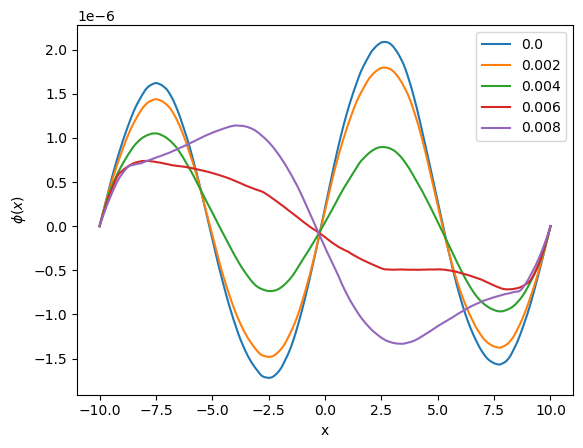

In [10]:
plt.plot(grid.grid,phi_v_time_arr[0,:])
plt.plot(grid.grid,phi_v_time_arr[200,:])
plt.plot(grid.grid,phi_v_time_arr[400,:])
plt.plot(grid.grid,phi_v_time_arr[600,:])
plt.plot(grid.grid,phi_v_time_arr[800,:])
times = [0,200*dt,400*dt,600*dt,800*dt]
times = np.array(times)
plt.legend([str(times[0]),str(times[1]),str(times[2]),str(times[3]),str(times[4])])
plt.xlabel('x')
plt.ylabel(r'$\phi(x)$')
plt.show()